In [1]:
# !pip install tensorflow

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory

image_size = (500,500)
batch_size = 1
seed = 42
class_names = [
    "Interacting with computer",
    "Photographing",
    "Playing Instrument",
    "Riding Bike",
    "Riding Horse",
    "Running",
    "Walking"
]

dataset_path = "./dataset"

print("Training set:")
train_set = image_dataset_from_directory(
    directory=dataset_path + "/TrainSet", 
    labels="inferred",
    label_mode="categorical",
    #class_names=class_names,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    crop_to_aspect_ratio=False,
    validation_split=0.12,
    subset="training",
    seed=seed
)

print("Validation set:")
val_set = image_dataset_from_directory(
    directory=dataset_path + "/TrainSet", 
    labels="inferred",
    label_mode="categorical",
    #class_names=class_names,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    crop_to_aspect_ratio=False,
    validation_split=0.12,
    subset="validation",
    seed=seed
)

print("Test set:")
test_set = image_dataset_from_directory(
    directory=dataset_path + "/TestSet", 
    labels="inferred",
    label_mode="categorical",
    #class_names=class_names,
    color_mode="rgb",
    batch_size=batch_size,
    image_size=image_size,
    crop_to_aspect_ratio=False
)


Training set:
Found 420 files belonging to 7 classes.
Using 370 files for training.
Validation set:
Found 420 files belonging to 7 classes.
Using 50 files for validation.
Test set:
Found 140 files belonging to 7 classes.


# Preview

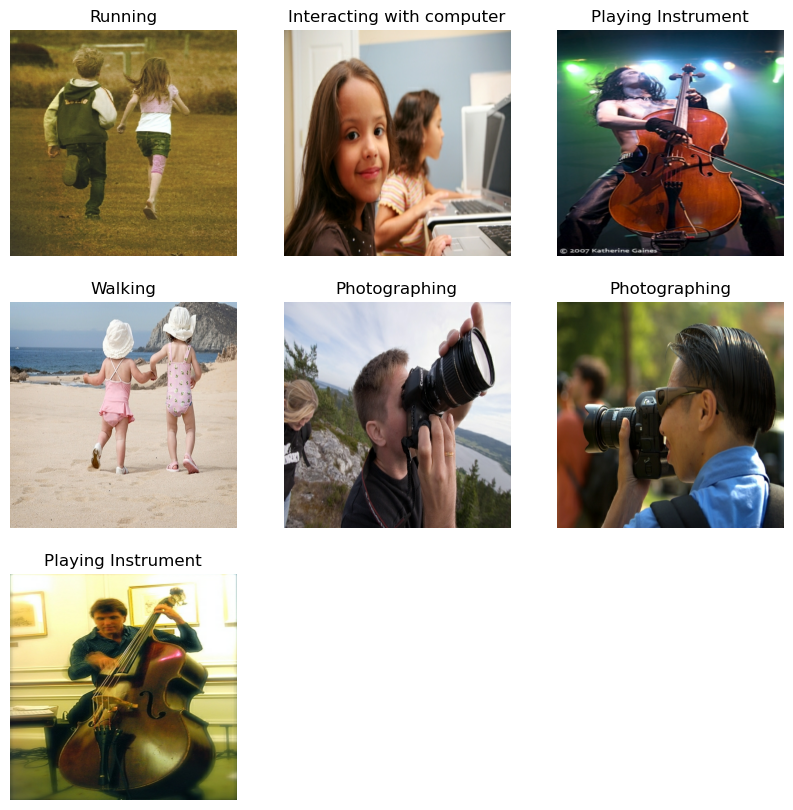

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
i = 0
for images, labels in train_set.take(len(class_names)):
    lbl=labels.numpy()
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[0].numpy().astype("uint8"))
    lbl_idx = [i for i in range(len(lbl[0])) if lbl[0][i] != 0][0]
    plt.title(class_names[lbl_idx])
    plt.axis("off")
    i+=1

# Model creation/ autoencoder

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from time import time
from datetime import timedelta
import random

def createCNN(input_shape, nb_classes):
    nb_filters = 32
    filter_size = (3, 3)
    max_pooling_size = (2, 2)
    inner_dropout_ratio = 0.4
    output_dropout_ratio = 0.2
    kernel_regularizer = l2(l=0.01)
    kernel_initializer="he_normal"
    random.seed(seed) # Establish Consistency in results
    
    # plain stack of layers with one input and one output
    model = Sequential() 
    
    model.add(Conv2D(nb_filters, filter_size, padding='same', activation='relu', 
                     kernel_initializer=kernel_initializer,
                     input_shape=input_shape, name="Conv2D_1"))
    #model.add(Conv2D(nb_filters, filter_size, activation='relu', name="Conv2D_2"))
    model.add(MaxPooling2D(pool_size=max_pooling_size, name="DownSampling_1"))
    model.add(Dropout(inner_dropout_ratio, name="Dropout_1"))

    # use two times more filters
    model.add(Conv2D(nb_filters*2, filter_size, padding='same', activation='relu', 
                     kernel_regularizer=kernel_regularizer, name="Conv2D_3"))
    #model.add(Conv2D(nb_filters*2, filter_size, activation='relu', name="Conv2D_4"))
    model.add(MaxPooling2D(pool_size=max_pooling_size, name="DownSampling_2"))
    model.add(Dropout(inner_dropout_ratio, name="Dropout_2"))
    
    model.add(Conv2D(nb_filters*2, filter_size, padding='same', activation='relu', 
                     kernel_regularizer=kernel_regularizer, name="Conv2D_5"))
    #model.add(Conv2D(nb_filters*2, filter_size, activation='relu', name="Conv2D_6"))
    model.add(MaxPooling2D(pool_size=max_pooling_size, name="DownSampling_3"))
    model.add(Dropout(inner_dropout_ratio, name="Dropout_3"))

    # convert dropout layer's output 3D array to 1D array
    flat_layer = Flatten()
    model.add(flat_layer)
    dense_size = model.output_shape[1]
    model.add(Dense(512, activation='relu', name="Dense_1"))
    #model.add(Dense(84, activation='relu', name="Dense_2"))
    model.add(Dropout(output_dropout_ratio, name="Dropout_4"))
    # classification over X classes
    model.add(Dense(nb_classes, activation='softmax', name="Predictions"))

    return model

input_shape = train_set.element_spec[0].shape[1:]
nb_classes = train_set.element_spec[1].shape[1]
model = createCNN(input_shape, nb_classes)

feature_extractor = Model(
    inputs=model.inputs,
    #outputs=[layer.output for layer in model.layers],
    outputs=model.get_layer(name="Conv2D_1").output,
)

### Let's check the model summary.

In [5]:
X = train_set
y = []
features = None
for element in X:
    y.append(model(element[0]))
    features = feature_extractor(element[0])
    break
    
model.summary()

'''
from matplotlib import pyplot as plt

#print(features[0][:,:,:3])
for feature in features:
    x1w = feature[:,:,:]
    for i in range(1,32):
      plt.subplot(6,6,i)
      plt.imshow(x1w[:,:,i],interpolation="nearest") # cmap="gray"
    plt.show()

for feature in features:
    print(feature)
    data = feature[0][0]
    plt.imshow(data, interpolation='nearest')
    plt.show()
    break
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 500, 500, 32)      896       
                                                                 
 DownSampling_1 (MaxPooling  (None, 250, 250, 32)      0         
 2D)                                                             
                                                                 
 Dropout_1 (Dropout)         (None, 250, 250, 32)      0         
                                                                 
 Conv2D_3 (Conv2D)           (None, 250, 250, 64)      18496     
                                                                 
 DownSampling_2 (MaxPooling  (None, 125, 125, 64)      0         
 2D)                                                             
                                                                 
 Dropout_2 (Dropout)         (None, 125, 125, 64)      0

'\nfrom matplotlib import pyplot as plt\n\n#print(features[0][:,:,:3])\nfor feature in features:\n    x1w = feature[:,:,:]\n    for i in range(1,32):\n      plt.subplot(6,6,i)\n      plt.imshow(x1w[:,:,i],interpolation="nearest") # cmap="gray"\n    plt.show()\n\nfor feature in features:\n    print(feature)\n    data = feature[0][0]\n    plt.imshow(data, interpolation=\'nearest\')\n    plt.show()\n    break\n'

# Model Training

## Let's start by defining an optimizer, a loss function and metrics to keep track of.

### Optimizer: RMSProp
### Loss: categorical cross-entropy because this a (7 class) classification problem
### Metrics: categorical accuracy

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# Optimizer
optimizer = RMSprop()
# Loss fuction to minimize
loss = CategoricalCrossentropy()
# Metrics to monitor
metrics = CategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

## Then we define the training parameters: number of epochs (50 to 100) and the batch size. The test data is used for validation.

In [7]:
batch_size = 32 # 32, 64, 256
epochs = 50 # 50, 100
time_start = time()
history = model.fit(train_set, epochs=epochs, 
                    batch_size=batch_size, verbose=1,
                    validation_data=val_set)
elapsed_time = time() - time_start
print(f"Training time: {timedelta(seconds=elapsed_time)}.")

Epoch 1/50

370/370 [==============================] - 678s 2s/step - loss: 754.4422 - categorical_accuracy: 0.1649 - val_loss: 2.5997 - val_categorical_accuracy: 0.1200
Epoch 2/50
370/370 [==============================] - 683s 2s/step - loss: 18.7443 - categorical_accuracy: 0.2000 - val_loss: 2.3490 - val_categorical_accuracy: 0.1200
Epoch 3/50
370/370 [==============================] - 672s 2s/step - loss: 11.5909 - categorical_accuracy: 0.2486 - val_loss: 2.5046 - val_categorical_accuracy: 0.1400
Epoch 4/50
370/370 [==============================] - 641s 2s/step - loss: 4.5969 - categorical_accuracy: 0.3622 - val_loss: 3.0743 - val_categorical_accuracy: 0.1000
Epoch 5/50
370/370 [==============================] - 631s 2s/step - loss: 3.1141 - categorical_accuracy: 0.5541 - val_loss: 8.5008 - val_categorical_accuracy: 0.1400
Epoch 6/50
370/370 [==============================] - 912s 2s/step - loss: 1.7799 - categorical_accuracy: 0.7838 - val_loss: 4.6775 - val_categorical_accuracy: 

370/370 [==============================] - 511s 1s/step - loss: 0.4266 - categorical_accuracy: 0.9865 - val_loss: 27.0498 - val_categorical_accuracy: 0.2000
Epoch 49/50
370/370 [==============================] - 520s 1s/step - loss: 0.2315 - categorical_accuracy: 0.9730 - val_loss: 10.9330 - val_categorical_accuracy: 0.2000
Epoch 50/50
370/370 [==============================] - 513s 1s/step - loss: 0.1185 - categorical_accuracy: 0.9811 - val_loss: 8.6369 - val_categorical_accuracy: 0.2200
Training time: 7:36:32.090049.


# Model validation [work in progress]

## Loss and accuracy

In [8]:
# !pip install numpy

Mean accuracy of 0.892, mean validation accuracy of 0.174
Mean loss of 16.604, mean validation loss of 19.821


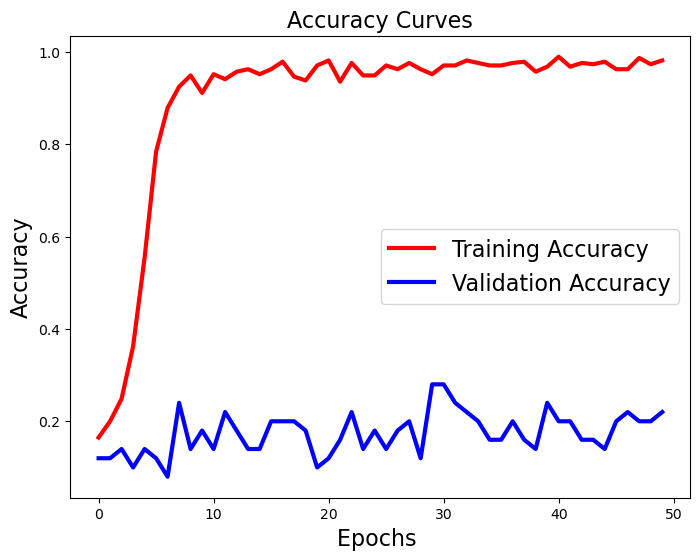

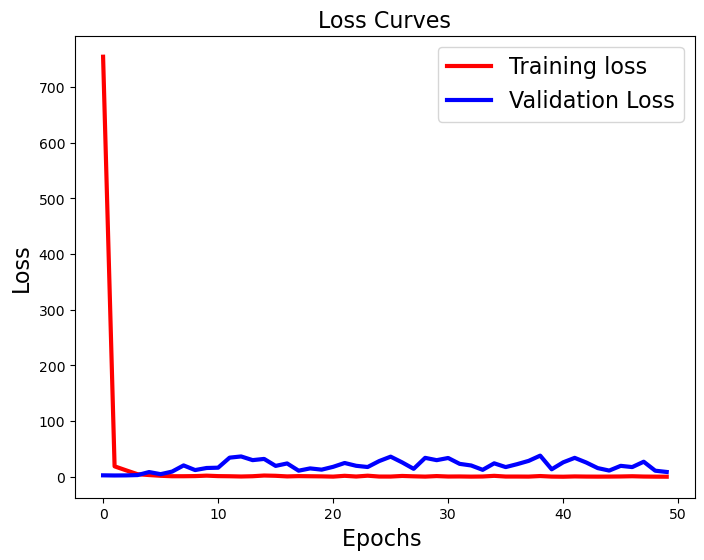

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['categorical_accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_categorical_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

print(f"Mean accuracy of {np.mean(history.history['categorical_accuracy']):.3f}, mean validation accuracy of {np.mean(history.history['val_categorical_accuracy']):.3f}")

# Loss curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

print(f"Mean loss of {np.mean(history.history['loss']):.3f}, mean validation loss of {np.mean(history.history['val_loss']):.3f}")

# Evaluation

### Let's evaluate our model and check its accuracy using the test set.

In [12]:
# write cross-val code
time_start = time()
model.evaluate(test_set)
elapsed_time = time() - time_start
print(f"Testing time: {timedelta(seconds=elapsed_time)}.")

140/140 [==============================] - 13s 81ms/step - loss: 10.9592 - categorical_accuracy: 0.1643
Testing time: 0:00:13.429557.


### Confusion matrix

140/140 [==============================] - 12s 82ms/step


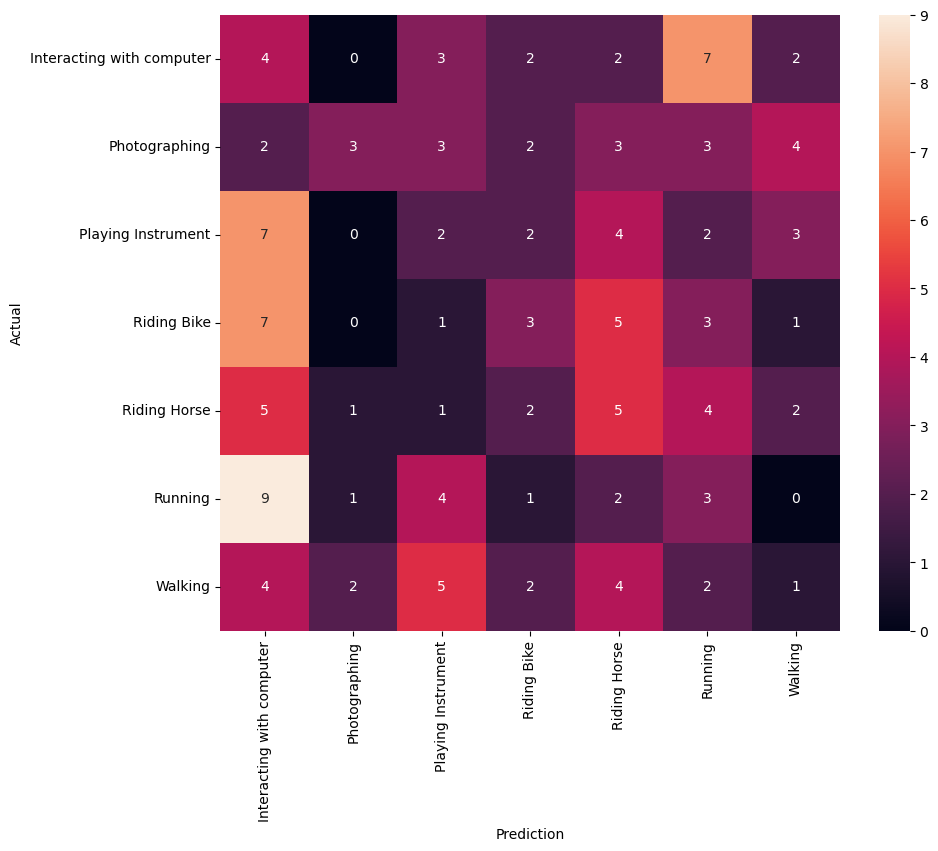

In [16]:
from tensorflow.math import confusion_matrix
from tensorflow import concat
from seaborn import heatmap

from tensorflow.keras.models import load_model
# model = load_model('./models/model_350x350_50_32.h5')

def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  plt.show()

predictions = model.predict(test_set)
predicted_labels = np.argmax(predictions, axis=-1)
target_labels = concat([label for img, label in test_set], axis=0)
target_labels = np.argmax(target_labels, axis=-1) # 1D

conf_matrix = confusion_matrix(predictions=predicted_labels, labels=target_labels, num_classes=len(class_names))
show_confusion_matrix(conf_matrix, test_set.class_names)

## Fine-tuning / retrain

### Since the model performance is satisfying after cross-validation, let's train the model with the entire dataset (train and test set).

In [19]:
from tensorflow.data import Dataset

batch_size = 32 # 32, 64, 256
epochs = 50 # 50, 100
time_start = time()

# Concatenate the datasets
entire_set = Dataset.concatenate(train_set, val_set)
entire_set = Dataset.concatenate(entire_set, test_set)

# entire_set = train_set + val_set + test_set
history = model.fit(train_set, epochs=epochs, 
          batch_size=batch_size, verbose=1, 
          validation_data=test_set)
elapsed_time = time() - time_start
print(f"Training time: {timedelta(seconds=elapsed_time)}.")

Epoch 1/50
370/370 [==============================] - 669s 2s/step - loss: 1.0132 - categorical_accuracy: 0.9703 - val_loss: 22.6977 - val_categorical_accuracy: 0.1857
Epoch 2/50
370/370 [==============================] - 530s 1s/step - loss: 0.2551 - categorical_accuracy: 0.9838 - val_loss: 16.2190 - val_categorical_accuracy: 0.1643
Epoch 3/50
370/370 [==============================] - 540s 1s/step - loss: 0.5382 - categorical_accuracy: 0.9676 - val_loss: 20.5558 - val_categorical_accuracy: 0.1643
Epoch 4/50
370/370 [==============================] - 894s 2s/step - loss: 1.0484 - categorical_accuracy: 0.9676 - val_loss: 27.0194 - val_categorical_accuracy: 0.1571
Epoch 5/50
370/370 [==============================] - 951s 3s/step - loss: 0.3443 - categorical_accuracy: 0.9757 - val_loss: 32.8728 - val_categorical_accuracy: 0.1857
Epoch 6/50
370/370 [==============================] - 740s 2s/step - loss: 0.2664 - categorical_accuracy: 0.9784 - val_loss: 26.6456 - val_categorical_accuracy:

370/370 [==============================] - 530s 1s/step - loss: 0.0899 - categorical_accuracy: 0.9892 - val_loss: 11.4979 - val_categorical_accuracy: 0.1786
Epoch 50/50
370/370 [==============================] - 527s 1s/step - loss: 0.1391 - categorical_accuracy: 0.9892 - val_loss: 13.9736 - val_categorical_accuracy: 0.2071
Training time: 8:34:22.774463.


## Model serialisation

### Let's save the model in a file for future use.

In [20]:
model.save(
    filepath="./models/model_" + str(image_size[0]) + "x" + str(image_size[1]) + "_" + 
    str(epochs) + "_" + str(batch_size) + ".h5",
    overwrite=False,
)

'''
# Load model later on 
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model = load_model('my_model.h5')
'''

C:\Users\Dell\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


"\n# Load model later on \nfrom keras.models import load_model\n# returns a compiled model\n# identical to the previous one\nmodel = load_model('my_model.h5')\n"